In [28]:
import pandas as pd
import numpy as np

In [29]:
df = pd.read_csv('/content/drive/MyDrive/BMKG/1. Kualitas Udara & AWS/dataset/final_dataset.csv')

In [30]:
df.head()

,Tanggal,pm25,rr,ws_avg,ws_max,wd_avg,wd_sin,wd_cos,tt_air_max,tt_air_avg,tt_air_min,rh_avg,sr_avg,pp_air,hour_sin,hour_cos,month_sin,month_cos
0,2024-01-01 07:00:00,35.2,20.4,0.796000,2.627331,250.771311,-0.568235,-0.198199,28.08,26.676667,25.25,89.321305,327.266667,990.462217,0.965926,-0.258819,0.5,0.866025
1,2024-01-01 08:00:00,9.1,0.0,0.654500,2.234687,213.220428,-0.322189,-0.491973,29.22,28.550000,27.80,80.528333,491.183333,991.110700,0.866025,-0.500000,0.5,0.866025
2,2024-01-01 09:00:00,18.5,0.0,0.835833,3.352323,218.088163,-0.605159,-0.772117,30.50,29.661667,28.91,75.260000,674.400000,991.152733,0.707107,-0.707107,0.5,0.866025
3,2024-01-01 10:00:00,17.5,0.0,1.110833,3.481706,223.482799,-0.619864,-0.653593,31.48,30.720000,30.18,70.248333,759.833333,990.364683,0.500000,-0.866025,0.5,0.866025
4,2024-01-01 11:00:00,23.0,0.0,1.436833,4.099219,226.547640,-0.641812,-0.608043,32.49,31.780000,31.19,64.065000,865.383333,989.523517,0.258819,-0.965926,0.5,0.866025


In [31]:
#untuk forecasting, harus ada fitur lag untuk melihat tren sebelumnya
df['pm25_lag1'] = df['pm25'].shift(1)
df['pm25_lag2'] = df['pm25'].shift(2)
df['pm25_lag3'] = df['pm25'].shift(3)
df.dropna(inplace=True)

In [32]:
# df.isnull().sum()

In [33]:
df.set_index('Tanggal', inplace=True)

## XGBoost : based on paper

In [34]:
import joblib
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

### MODEL VERSI SIMPEL (Hanya Lag-1) input 1pm saat ini

In [35]:
# Definisi Fitur: Cuaca + Waktu + CUMA Lag-1
features_simpel = [c for c in df.columns if c not in ['pm25', 'wd_avg', 'pm25_lag2', 'pm25_lag3', 'tt_air_max', 'tt_air_min']]
# features_simpel = [c for c in df.columns if c not in ['pm25', 'wd_avg', 'pm25_lag2', 'pm25_lag3']]
X_simpel = df[features_simpel]
y_simpel = df['pm25']

# Split
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_simpel, y_simpel, test_size=0.15, shuffle=False)

In [36]:
print(list(X_simpel.columns))

['rr', 'ws_avg', 'ws_max', 'wd_sin', 'wd_cos', 'tt_air_avg', 'rh_avg', 'sr_avg', 'pp_air', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'pm25_lag1']


In [37]:
model_simpel = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=7, random_state=42, n_jobs=-1)
model_simpel.fit(X_train_s, y_train_s)

# Evaluasi
pred_s = model_simpel.predict(X_test_s)

mae_s = mean_absolute_error(y_test_s, pred_s)
rmse_s = np.sqrt(mean_squared_error(y_test_s, pred_s))
r2_s = r2_score(y_test_s, pred_s)
print(f"Hasil Simpel (Lag-1): MAE = {mae_s:.2f} | R2 = {r2_s:.4f} | RMSE = {rmse_s:.2f}")

Hasil Simpel (Lag-1): MAE = 6.59 | R2 = 0.5767 | RMSE = 8.88


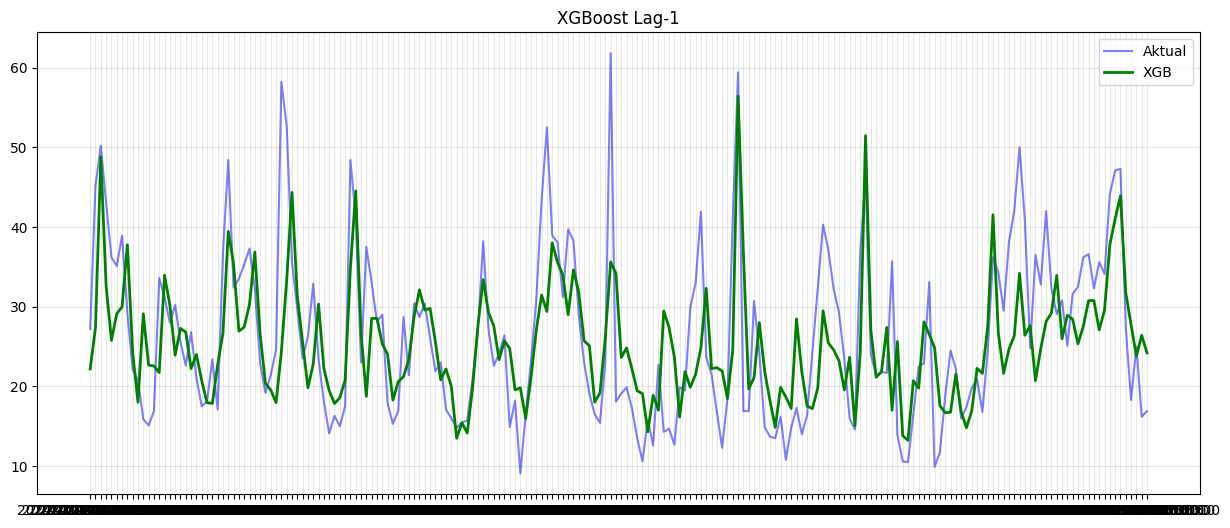

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
limit = 200
plt.plot(y_test_s.index[:limit], y_test_s.iloc[:limit], label='Aktual', color='blue', alpha=0.5)
plt.plot(y_test_s.index[:limit], pred_s[:limit], label='XGB', color='green', linewidth=2)
plt.title('XGBoost Lag-1')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### coba rf

In [39]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=15,
    min_samples_leaf=10,
    # max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_s, y_train_s)

RandomForestRegressor(max_depth=15, min_samples_leaf=10, n_estimators=500,
                      n_jobs=-1, random_state=42)

In [40]:
import numpy as np


y_train_log = np.log1p(y_train_s)
rf.fit(X_train_s, y_train_log)

y_pred = np.expm1(rf.predict(X_test_s))

# y_pred = rf.predict(X_test_s)

mae = mean_absolute_error(y_test_s, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_s, y_pred))
r2 = r2_score(y_test_s, y_pred)

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R2   : {r2:.4f}")

MAE  : 5.74
RMSE : 8.22
R2   : 0.6375


In [42]:
rf.fit(X_train_s, y_train_s)
y_pred = rf.predict(X_test_s)

mae = mean_absolute_error(y_test_s, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_s, y_pred))
r2 = r2_score(y_test_s, y_pred)

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R2   : {r2:.4f}")

MAE  : 5.59
RMSE : 7.72
R2   : 0.6797


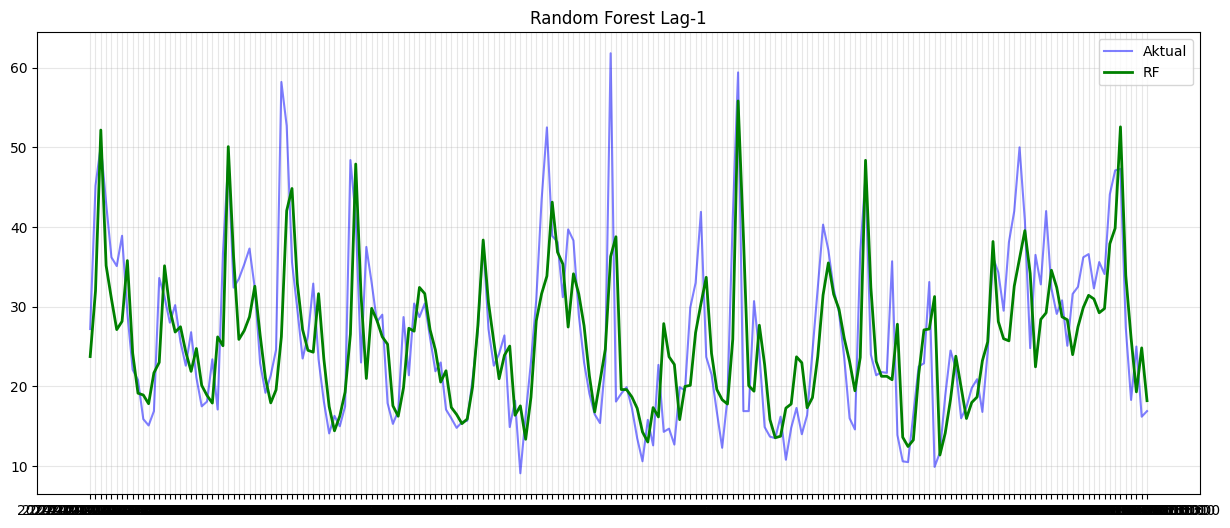

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
limit = 200
plt.plot(y_test_s.index[:limit], y_test_s.iloc[:limit], label='Aktual', color='blue', alpha=0.5)
plt.plot(y_test_s.index[:limit], y_pred[:limit], label='RF', color='green', linewidth=2)
plt.title('Random Forest Lag-1')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [15]:
features_simpel = X_train_s.columns.tolist() # Ambil dari X_train_s yg tadi

joblib.dump(
    {
        'model': rf,
        'features': features_simpel,
        'desc': 'Simple Forecast (Input: Cuaca + PM2.5 Saat Ini)'
    },
    'rf_pm25_simpel.joblib'
)
print("Simple Model Saved.")

Simple Model Saved.


In [25]:
print(features_simpel)

['rr', 'ws_avg', 'ws_max', 'wd_sin', 'wd_cos', 'tt_air_avg', 'rh_avg', 'sr_avg', 'pp_air', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'pm25_lag1']


## Lag 2 Lag 3

In [16]:
features_123 = [c for c in df.columns if c not in ['pm25', 'wd_avg', 'tt_air_max', 'tt_air_min']]
X_pro = df[features_123]
y_pro = df['pm25']

In [17]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_pro, y_pro, test_size=0.15, shuffle=False)

## XGBoost

In [18]:
model_pro = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=7, random_state=100, n_jobs=-1)
model_pro.fit(X_train_p, y_train_p)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, num_parallel_tree=None, ...)

In [19]:
pred_p = model_pro.predict(X_test_p)

mae_p = mean_absolute_error(y_test_p, pred_p)
rmse_p = np.sqrt(mean_squared_error(y_test_p, pred_p))
r2_p = r2_score(y_test_p, pred_p)
print(f"Hasil Pro (Lag-123): MAE = {mae_p:.2f} | R2 = {r2_p:.4f} | RMSE = {rmse_p:.2f}")

Hasil Pro (Lag-123): MAE = 6.41 | R2 = 0.6267 | RMSE = 8.34


## RF

In [20]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=15,
    min_samples_leaf=10,
    # max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_p, y_train_p)

RandomForestRegressor(max_depth=15, min_samples_leaf=10, n_estimators=500,
                      n_jobs=-1, random_state=42)

In [21]:
import numpy as np

y_pred_rf_123 = rf.predict(X_test_p)

mae = mean_absolute_error(y_test_p, y_pred_rf_123)
rmse = np.sqrt(mean_squared_error(y_test_p, y_pred_rf_123))
r2 = r2_score(y_test_p, y_pred_rf_123)

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R2   : {r2:.4f}")

MAE  : 5.30
RMSE : 7.08
R2   : 0.7305


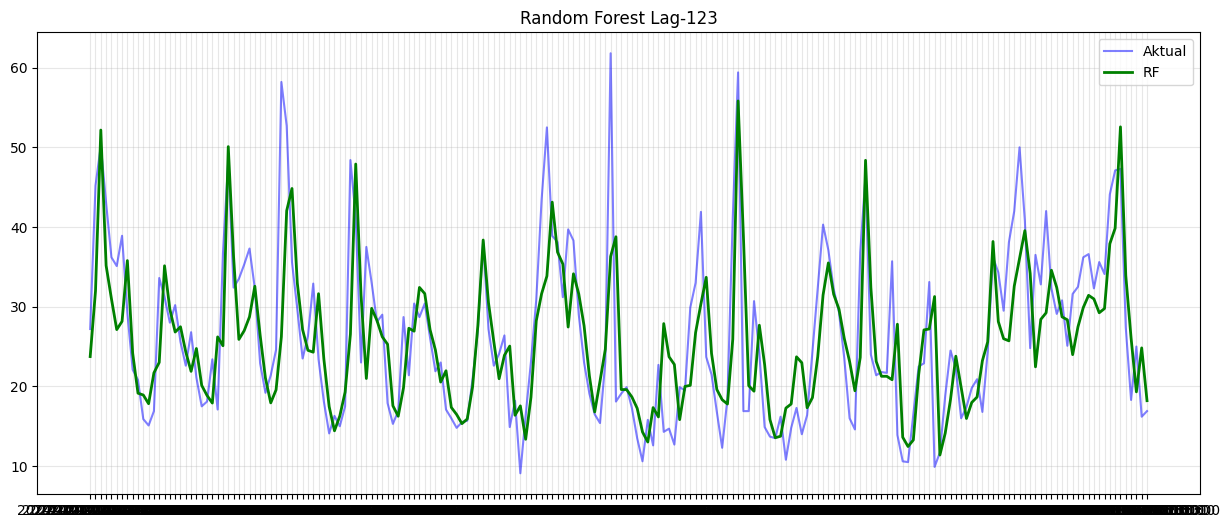

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
limit = 200
plt.plot(y_test_s.index[:limit], y_test_s.iloc[:limit], label='Aktual', color='blue', alpha=0.5)
plt.plot(y_test_s.index[:limit], y_pred[:limit], label='RF', color='green', linewidth=2)
plt.title('Random Forest Lag-123')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [23]:
features_pro = X_train_p.columns.tolist() # Ambil dari X_train_p yg tadi

joblib.dump(
    {
        'model': rf,
        'features': features_pro,
        'desc': 'Pro Forecast (Input: Cuaca + PM2.5 History 3 Jam)'
    },
    'rf_pm25_pro.joblib'
)
print("Pro Model Saved.")

Pro Model Saved.


In [24]:
print(features_pro)

['rr', 'ws_avg', 'ws_max', 'wd_sin', 'wd_cos', 'tt_air_avg', 'rh_avg', 'sr_avg', 'pp_air', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'pm25_lag1', 'pm25_lag2', 'pm25_lag3']


In [43]:
df.head()

,pm25,rr,ws_avg,ws_max,wd_avg,wd_sin,wd_cos,tt_air_max,tt_air_avg,tt_air_min,rh_avg,sr_avg,pp_air,hour_sin,hour_cos,month_sin,month_cos,pm25_lag1,pm25_lag2,pm25_lag3
Tanggal,,,,,,,,,,,,,,,,,,,,
2024-01-01 10:00:00,17.5,0.0,1.110833,3.481706,223.482799,-0.619864,-0.653593,31.48,30.720000,30.18,70.248333,759.833333,990.364683,5.000000e-01,-0.866025,0.5,0.866025,18.5,9.1,35.2
2024-01-01 11:00:00,23.0,0.0,1.436833,4.099219,226.547640,-0.641812,-0.608043,32.49,31.780000,31.19,64.065000,865.383333,989.523517,2.588190e-01,-0.965926,0.5,0.866025,17.5,18.5,9.1
2024-01-01 12:00:00,15.6,0.0,2.848500,7.071497,252.544841,-0.899544,-0.282851,33.11,32.095000,30.15,66.886667,611.966667,988.651950,1.224647e-16,-1.000000,0.5,0.866025,23.0,17.5,18.5
2024-01-01 13:00:00,22.3,0.0,2.336833,5.678655,223.765032,-0.669903,-0.699423,30.44,29.288333,28.55,82.675000,421.316667,987.817167,-2.588190e-01,-0.965926,0.5,0.866025,15.6,23.0,17.5
2024-01-01 14:00:00,18.9,0.0,2.861167,5.876456,239.181387,-0.845493,-0.504387,31.64,30.910000,30.01,72.251667,691.550000,987.301200,-5.000000e-01,-0.866025,0.5,0.866025,22.3,15.6,23.0
